In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r"/content/Order coordinates.csv",index_col=0)
data.head()

,Lat,Long
Order ID,,
1,12.925978,77.615465
2,12.902758,77.593012
3,12.921465,77.734314
4,12.931535,77.678150
5,13.012142,77.511389


In [3]:
data.isnull().sum()

,0
Lat,0
Long,0


In [4]:
x = data.values[:,[0,1]]
x

array([[12.925978 , 77.615465 ],
       [12.9027579, 77.5930124],
       [12.9214653, 77.7343139],
       ...,
       [13.122228 , 77.630567 ],
       [13.124449 , 77.629451 ],
       [13.124535 , 77.63038  ]])

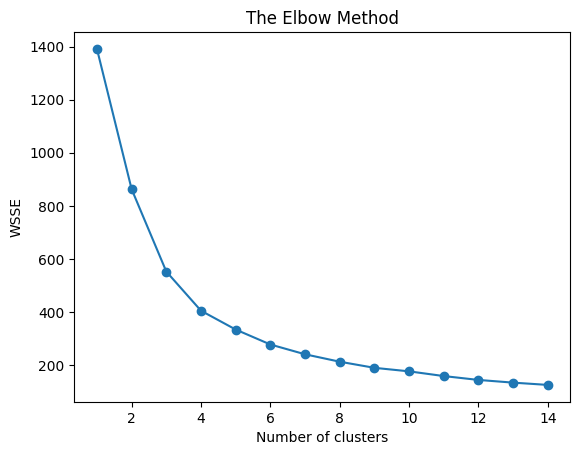

In [5]:
from sklearn.cluster import KMeans

wsse = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i,  random_state = 10)
    kmeans.fit(x)
    wsse.append(kmeans.inertia_)
plt.plot(range(1, 15), wsse)
plt.scatter(range(1, 15),wsse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WSSE')
plt.show()

In [6]:
print(wsse)

[1391.779196544823, 862.6169333580897, 551.8533827142305, 404.148085681491, 333.16022831764525, 276.7364940042781, 239.8120285265856, 211.7963183921037, 188.75371980510997, 175.44423723625968, 157.67182698387947, 143.06345560691926, 132.8968213693303, 124.2689665178556]


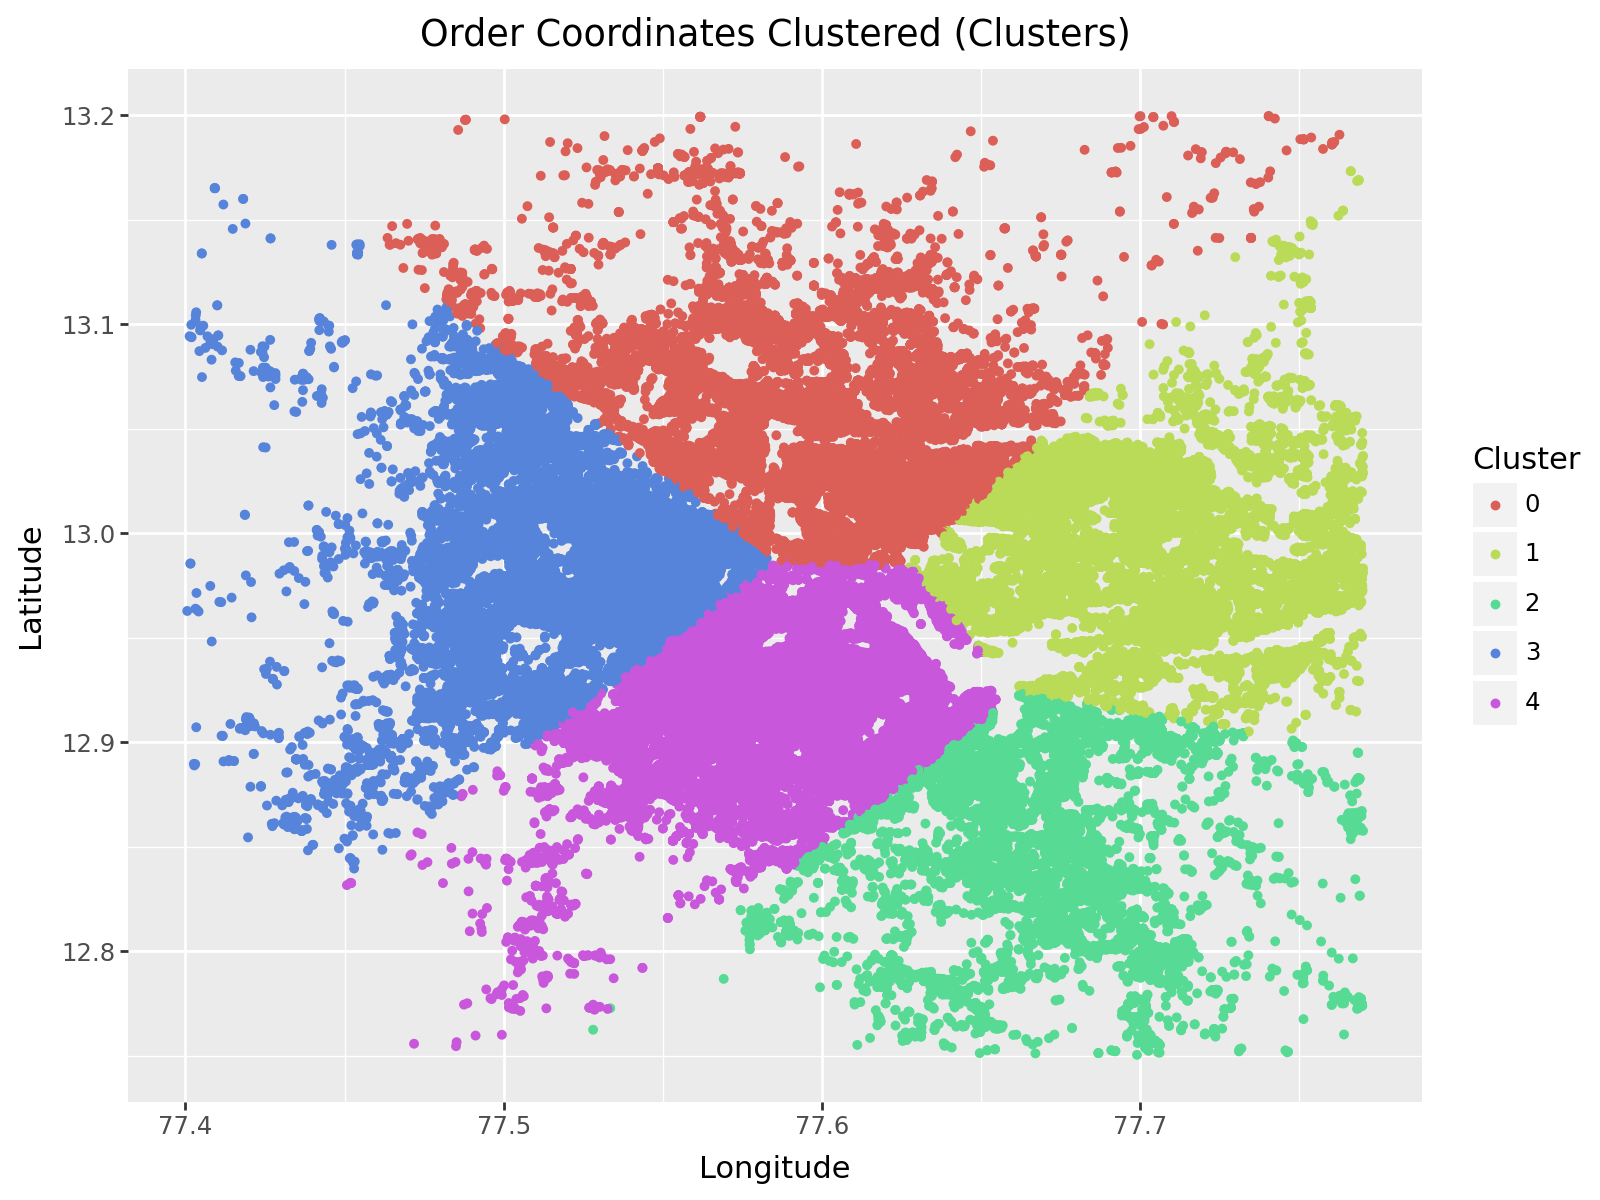

In [7]:
kmeans = KMeans(n_clusters=5, random_state=10)
y_kmeans = kmeans.fit_predict(x)

# Add the cluster results to the original dataframe
data['cluster'] = y_kmeans

# Visualize the clusters
from plotnine import ggplot, aes, geom_point, labs, theme

(
    ggplot(data)
    + aes(x='Long', y='Lat', color='factor(cluster)')
    + geom_point(size=1)
    + labs(
        title='Order Coordinates Clustered (Clusters)',
        x='Longitude',
        y='Latitude',
        color='Cluster'
    )
    + theme(figure_size=(8, 6))
)

In [8]:
%pip install folium plotly

In [9]:
map_data = data[['Lat', 'Long', 'cluster']].copy()
print(map_data.dtypes)
print(map_data.head())

Lat        float64
Long       float64
cluster      int32
dtype: object
                Lat       Long  cluster
Order ID                               
1         12.925978  77.615465        4
2         12.902758  77.593012        4
3         12.921465  77.734314        1
4         12.931535  77.678150        1
5         13.012142  77.511389        3


In [10]:
import folium

center_lat = map_data['Lat'].mean()
center_long = map_data['Long'].mean()

m = folium.Map(location=[center_lat, center_long], zoom_start=10)
m

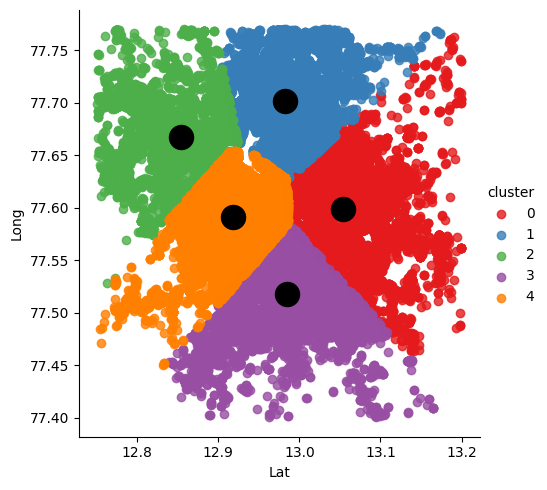

In [11]:
sns.lmplot( data=data, x='Lat', y='Long',
           fit_reg=False, # No regression line
           hue='cluster',palette="Set1")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
     s = 300, c = 'black')
plt.show()

**Haversine Formula to calculate Distance**

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

**Distance with 100% Coverage**

In [13]:
centers = kmeans.cluster_centers_

map_data['distance_km'] = map_data.apply(
    lambda row: haversine(
        row['Lat'], row['Long'],
        centers[int(row['cluster'])][0], centers[int(row['cluster'])][1]
    ),
    axis=1
)
cluster_stats = map_data.groupby('cluster')['distance_km'].agg(
    avg_distance_km='mean',
    p90_distance_km=lambda x: np.percentile(x, 90)
).reset_index()

print(cluster_stats)

   cluster  avg_distance_km  p90_distance_km
0        0         5.156821         7.728161
1        1         4.534215         6.972390
2        2         4.649839         8.191964
3        3         5.373313         9.518416
4        4         4.294227         6.692446


**Cost With 100% Coverage**

In [14]:
COST_PER_KM = 10
FIXED_STORE_COST = 500000
total_cost_100_coverage_per_cluster = map_data.groupby('cluster')['distance_km'].sum() * COST_PER_KM + FIXED_STORE_COST
overall_total_cost_100_coverage = total_cost_100_coverage_per_cluster.sum()
print("Total cost for 100% coverage per cluster:\n", abs(total_cost_100_coverage_per_cluster))
print("\nOverall total cost for 100% coverage:", abs(overall_total_cost_100_coverage))

Total cost for 100% coverage per cluster:
 cluster
0    1.936742e+06
1    2.037054e+06
2    1.142468e+06
3    1.892279e+06
4    2.145548e+06
Name: distance_km, dtype: float64

Overall total cost for 100% coverage: 9154090.84256117


**Overall Distance Considering One clusture**

In [15]:
overall_center_lat = data['Lat'].mean()
overall_center_long = data['Long'].mean()

total_distance_one_cluster = data.apply(
    lambda row: haversine(
        row['Lat'], row['Long'],
        overall_center_lat, overall_center_long
    ),
    axis=1
).sum()

total_cost_one_cluster = total_distance_one_cluster * COST_PER_KM + FIXED_STORE_COST

print(f"Total distance considering the whole area as one cluster: {total_distance_one_cluster:.2f} km")
print(f"Total cost considering the whole area as one cluster: {total_cost_one_cluster:.2f}")

Total distance considering the whole area as one cluster: 1395720.83 km
Total cost considering the whole area as one cluster: 14457208.28


**Center of Cluster**

In [16]:
# Calculate the weighted centroid
# Assuming each order has equal weight for simplicity, the weighted centroid is the mean of Lat and Long
weighted_center_lat = data['Lat'].mean()
weighted_center_long = data['Long'].mean()

print(f"Weighted City Center (Latitude, Longitude): ({weighted_center_lat:.6f}, {weighted_center_long:.6f})")

Weighted City Center (Latitude, Longitude): (12.966552, 77.613784)


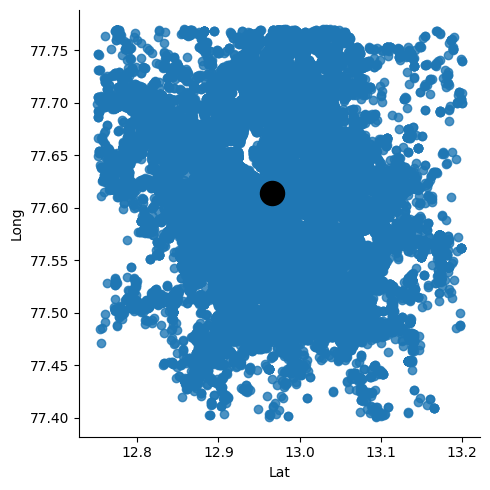

In [17]:
sns.lmplot( data=data, x='Lat', y='Long',
           fit_reg=False)
plt.scatter(weighted_center_lat,weighted_center_long,
     s = 300, c = 'black')
plt.show()

In [18]:
# Calculate distance from the weighted city center for each order
data['distance_from_weighted_center'] = data.apply(
    lambda row: haversine(
        row['Lat'], row['Long'],
        weighted_center_lat, weighted_center_long
    ),
    axis=1
)
print(data[['distance_from_weighted_center']].head())

          distance_from_weighted_center
Order ID                               
1                              4.515246
2                              7.442140
3                             13.990839
4                              7.988328
5                             12.197760


**KDE Algorithm**

In [19]:
from scipy.stats import gaussian_kde
# Extract the coordinates
x_coords = data['Long'].values
y_coords = data['Lat'].values
# Combine the coordinates
xy = np.vstack([x_coords, y_coords])
# Perform Kernel Density Estimation
kde = gaussian_kde(xy)
# Evaluate the KDE on a grid
x_min, x_max = x_coords.min(), x_coords.max()
y_min, y_max = y_coords.min(), y_coords.max()
# Create a grid
X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

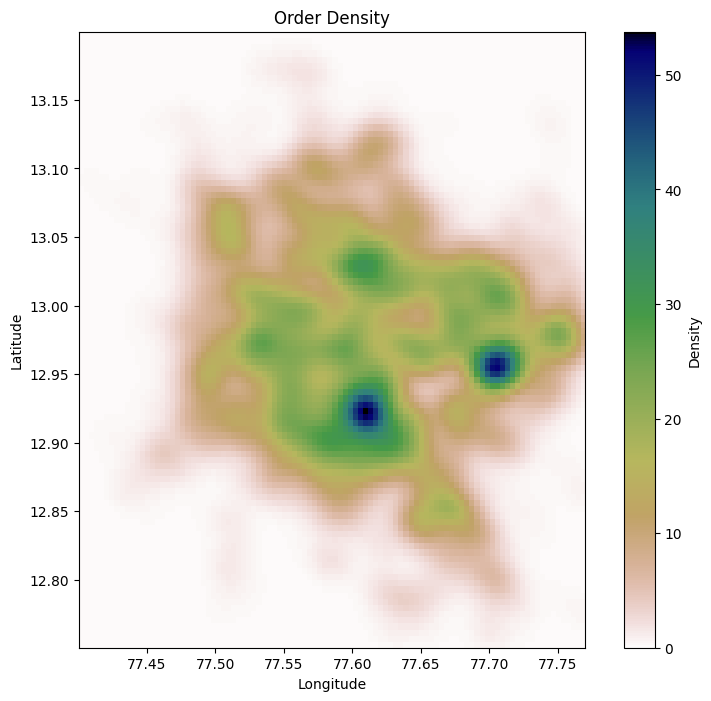

In [20]:
# Visualize the density using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label='Density')
plt.title('Order Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**By Distance and Density Filter**

In [21]:
# Calculate density for each point
data['density'] = kde(np.vstack([data['Long'], data['Lat']]))

# Define thresholds
dist_threshold = data['distance_from_weighted_center'].quantile(0.95)
dens_threshold = data.loc[data['distance_from_weighted_center'] > dist_threshold, 'density'].quantile(0.10)

# Filter out low-density, far-away points
mask = ~((data['distance_from_weighted_center'] > dist_threshold) & (data['density'] < dens_threshold))
data_filtered = data[mask]

# Summary
print(f"Removed {len(data) - len(data_filtered)} orders.")
print(f"Remaining: {len(data_filtered)} orders.")

Removed 699 orders.
Remaining: 139109 orders.


**Comparison of Overall and Filtered Order Data**

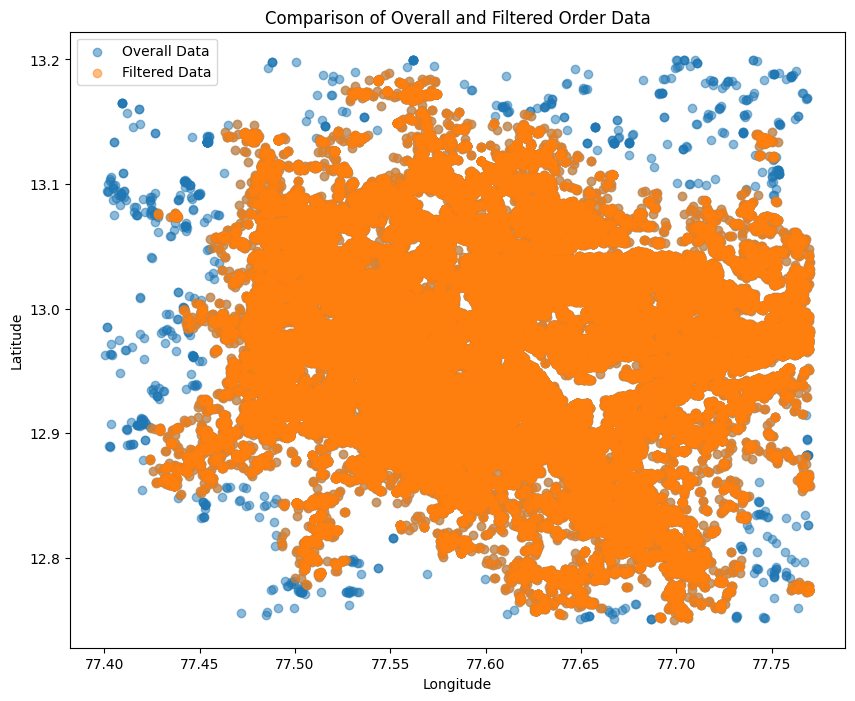

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(data['Long'], data['Lat'], alpha=0.5, label='Overall Data')
plt.scatter(data_filtered['Long'], data_filtered['Lat'], alpha=0.5, label='Filtered Data')
plt.title('Comparison of Overall and Filtered Order Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

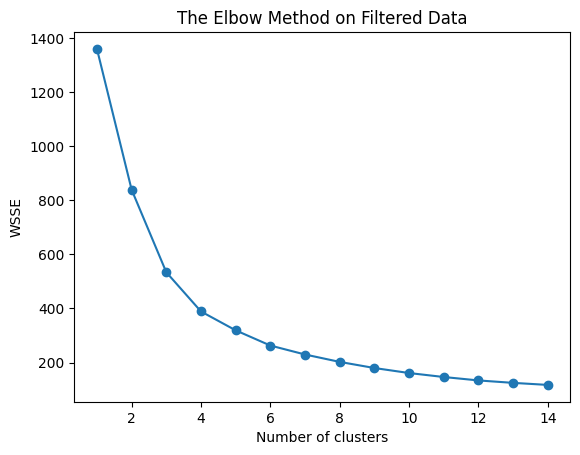

In [25]:
from sklearn.cluster import KMeans

x_filtered = data_filtered[['Lat', 'Long']].values

wsse_filtered = []
for i in range(1, 15):
    kmeans_filtered = KMeans(n_clusters = i,  random_state = 10, n_init=10)
    kmeans_filtered.fit(x_filtered)
    wsse_filtered.append(kmeans_filtered.inertia_)

plt.plot(range(1, 15), wsse_filtered)
plt.scatter(range(1, 15),wsse_filtered)
plt.title('The Elbow Method on Filtered Data')
plt.xlabel('Number of clusters')
plt.ylabel('WSSE')
plt.show()

**100% Coverage**

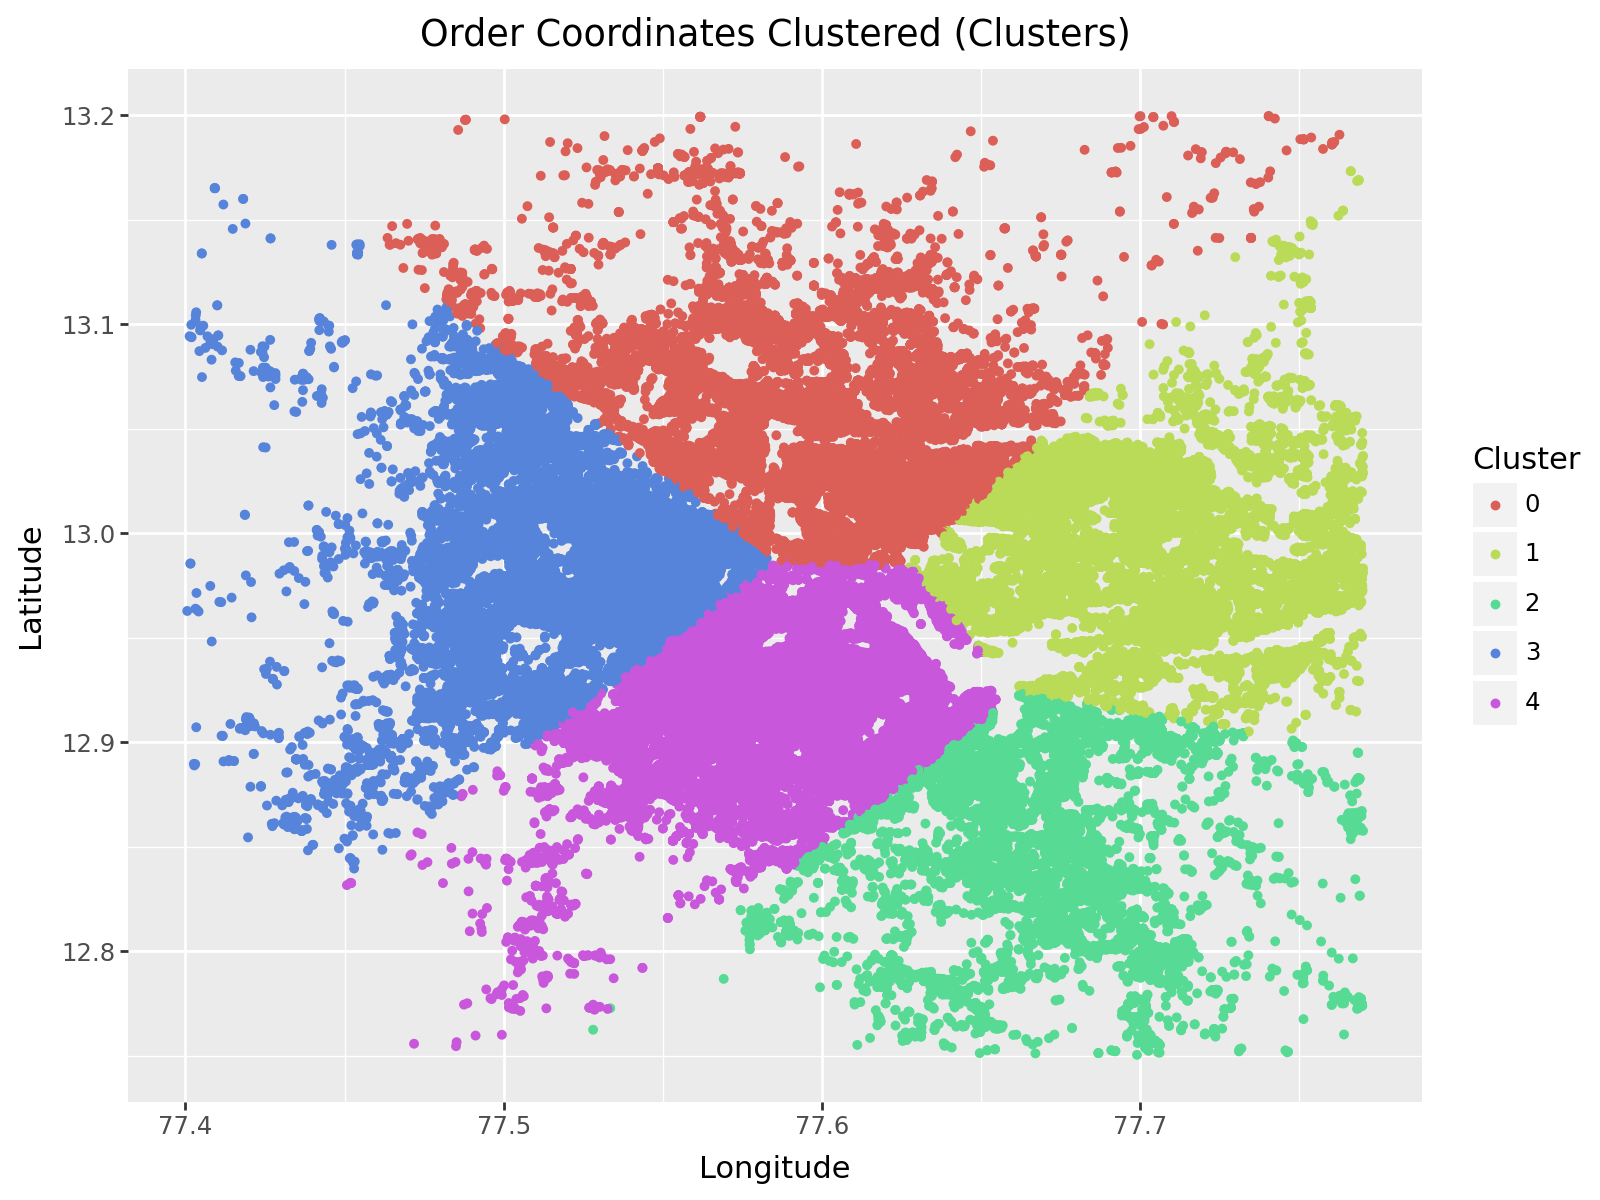

In [26]:
kmeans = KMeans(n_clusters=5, random_state=10)
y_kmeans = kmeans.fit_predict(x)

# Add the cluster results to the original dataframe
data['cluster'] = y_kmeans

# Visualize the clusters
from plotnine import ggplot, aes, geom_point, labs, theme

(
    ggplot(data)
    + aes(x='Long', y='Lat', color='factor(cluster)')
    + geom_point(size=1)
    + labs(
        title='Order Coordinates Clustered (Clusters)',
        x='Longitude',
        y='Latitude',
        color='Cluster'
    )
    + theme(figure_size=(8, 6))
)

**95% Coverage**

/tmp/ipython-input-544265703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


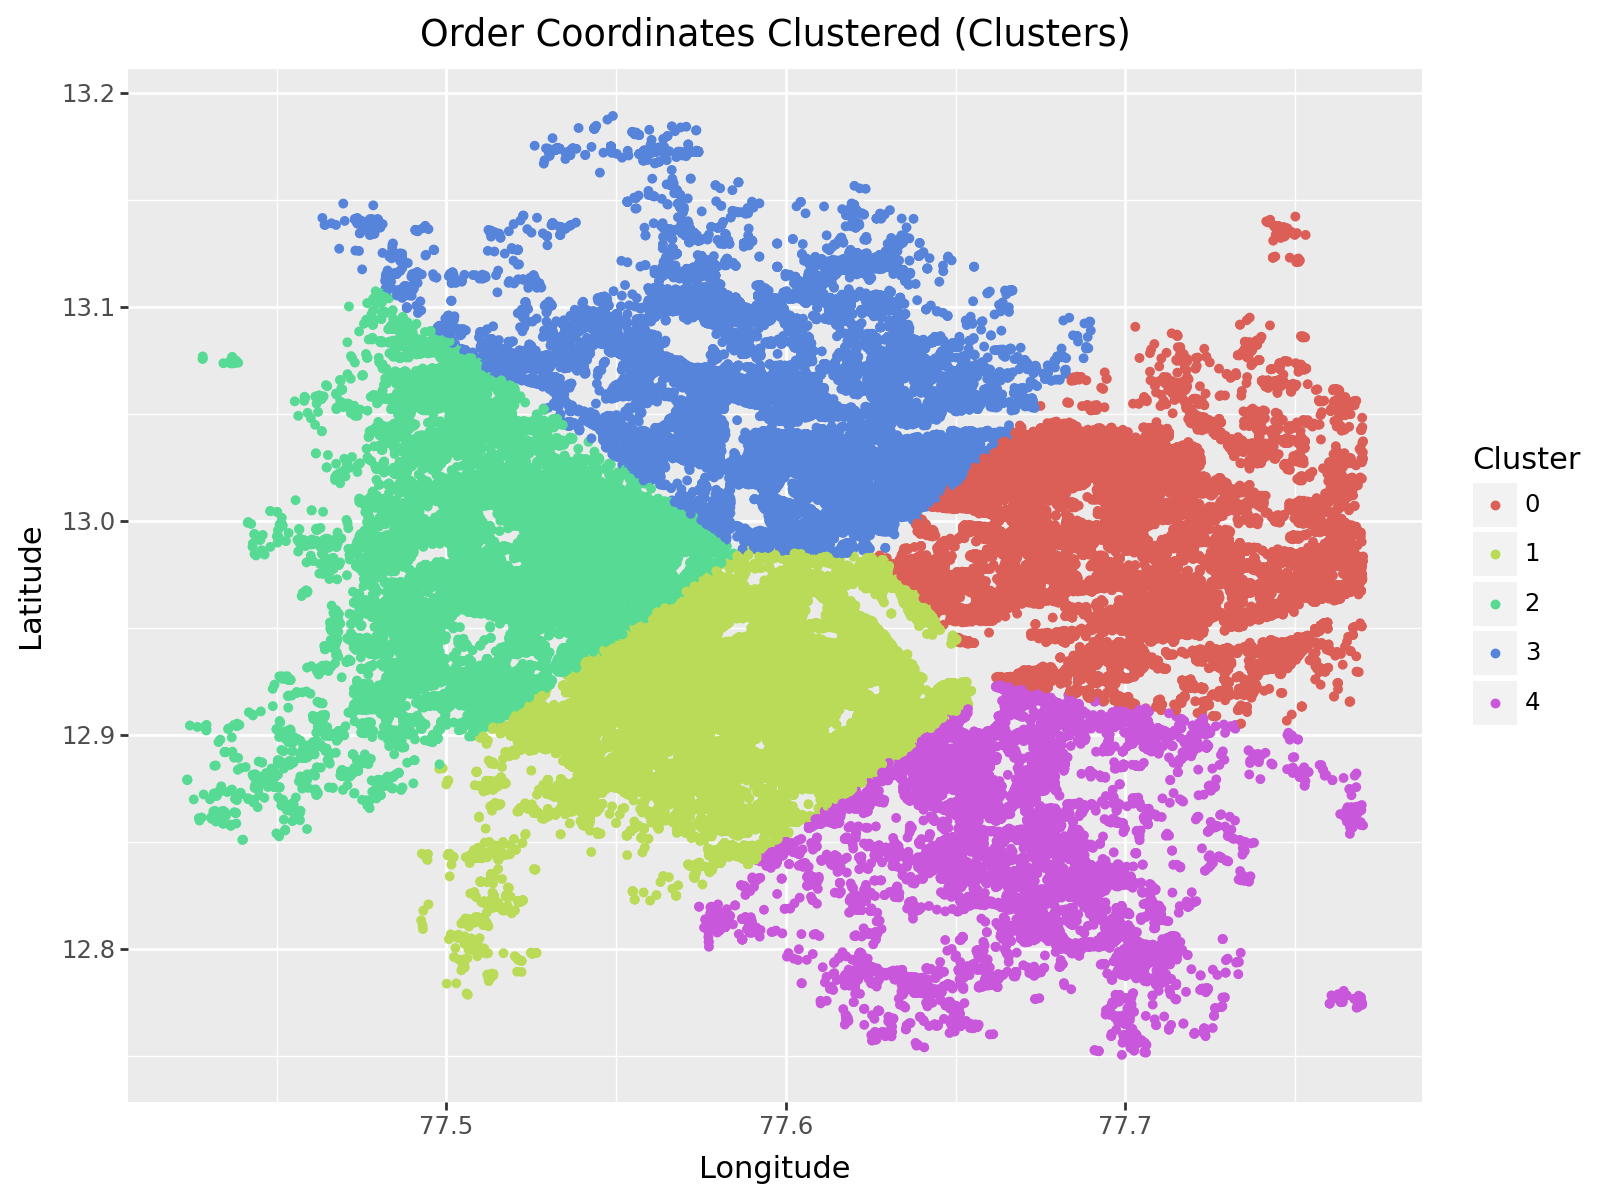

In [28]:
kmeans = KMeans(n_clusters=5, random_state=10)
y_kmeans = kmeans.fit_predict(x_filtered)

# Add the cluster results to the original dataframe
data_filtered['cluster'] = y_kmeans

# Visualize the clusters
from plotnine import ggplot, aes, geom_point, labs, theme

(
    ggplot(data_filtered)
    + aes(x='Long', y='Lat', color='factor(cluster)')
    + geom_point(size=1)
    + labs(
        title='Order Coordinates Clustered (Clusters)',
        x='Longitude',
        y='Latitude',
        color='Cluster'
    )
    + theme(figure_size=(8, 6))
)

In [30]:
map_data1 = data_filtered[['Lat', 'Long', 'cluster']].copy()
print(map_data1.dtypes)
print(map_data1.head())

Lat        float64
Long       float64
cluster      int32
dtype: object
                Lat       Long  cluster
Order ID                               
1         12.925978  77.615465        1
2         12.902758  77.593012        1
3         12.921465  77.734314        0
4         12.931535  77.678150        0
5         13.012142  77.511389        2


In [31]:
centers = kmeans.cluster_centers_

map_data1['distance_km1'] = map_data1.apply(
    lambda row: haversine(
        row['Lat'], row['Long'],
        centers[int(row['cluster'])][0], centers[int(row['cluster'])][1]
    ),
    axis=1
)
cluster_stats = map_data1.groupby('cluster')['distance_km1'].agg(
    avg_distance_km='mean',
    p90_distance_km=lambda x: np.percentile(x, 90)
).reset_index()

print(cluster_stats)

   cluster  avg_distance_km  p90_distance_km
0        0         4.514402         6.959718
1        1         4.246736         6.665504
2        2         5.234229         9.284146
3        3         5.100647         7.754700
4        4         4.603987         8.118025


In [32]:
COST_PER_KM = 10
FIXED_STORE_COST = 500000
total_cost_95_coverage = map_data1.groupby('cluster')['distance_km1'].sum() * COST_PER_KM + FIXED_STORE_COST
overall_total_cost_95_coverage = total_cost_95_coverage.sum()
print("Total cost for 95% coverage per cluster:\n", abs(total_cost_95_coverage))
print("\nOverall total cost for 95% coverage:", abs(overall_total_cost_95_coverage))

Total cost for 95% coverage per cluster:
 cluster
0    2.026771e+06
1    2.108706e+06
2    1.850065e+06
3    1.922367e+06
4    1.132081e+06
Name: distance_km1, dtype: float64

Overall total cost for 95% coverage: 9039989.757525442
